In [1]:
import time
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchtext.data import to_map_style_dataset

from reviews_dataset import reviews
from trainer import Trainer
import os
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [68]:
reviews_labels = {0: "Negative",
                    1: "Neutral",
                    2: "Positive"}

def train(trainer: Trainer, train_dataloader: DataLoader, valid_dataloader: DataLoader, EPOCHS = 10, LR = 5, BATCH_SIZE = 64):
    total_accu = None
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        trainer.train(train_dataloader, epoch)
        accu_val = trainer.evaluate(valid_dataloader)
        if total_accu is not None and total_accu > accu_val:
            trainer.scheduler.step()
        else:
            total_accu = accu_val
        print('-' * 59)
        print('| end of epoch {:3d} | time: {:5.2f}s | '
              'valid accuracy {:8.3f} '.format(epoch,
                                               time.time() - epoch_start_time,
                                               accu_val))
        print('-' * 59)

def predict(trainer, dataloader: DataLoader):
    trainer.model.eval()
    preds = np.array([])
    labels = np.array([])

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = trainer.model(text, offsets)
            preds = np.concatenate([preds, predicted_label.argmax(1).cpu().numpy()])
            labels = np.concatenate([labels, label.cpu().numpy()])
    return preds, labels

def evaluate(trainer, dataloader, experimentName):
    preds, y_test = predict(trainer, dataloader)
    accuracy = accuracy_score(preds, y_test)
    recall = recall_score(preds, y_test, average=None)
    cm = confusion_matrix(preds, y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg','neu','pos'])
    f1 = f1_score(preds, y_test, average=None)
    disp.plot()

    return pd.DataFrame({'experimentName':[experimentName], 'accuracy':[np.round(accuracy, 3)], 'recall':[np.round(recall, 3)], 'f1_score':[np.round(f1,3)], 'training samples':[len(train_dataloader.dataset)]})

def getDatasets(dataset_path, BATCH_SIZE, trainer):
    train_iter, test_iter = reviews(root=dataset_path)
    train_dataset = to_map_style_dataset(train_iter)
    test_dataset = to_map_style_dataset(test_iter)
    num_train = int(len(train_dataset) * 0.95)
    split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

    train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                                    shuffle=True, collate_fn=trainer.collate_batch)
    valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                                    shuffle=True, collate_fn=trainer.collate_batch)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                    shuffle=True, collate_fn=trainer.collate_batch)
    return train_dataloader, valid_dataloader
    
def predictSingleEntry(trainer, text):
    with torch.no_grad():
        text = torch.tensor(trainer.text_pipeline(text))
        output = trainer.model.to('cpu')(text, torch.tensor([0]))
        return output.argmax(1).item()

In [72]:
results = pd.DataFrame(columns=['experimentName', 'accuracy', 'recall', 'f1_score', 'training samples'])

In [3]:
ptm = pd.read_json("FinalDatasets/complete_dataset_ptm.json")

<AxesSubplot:>

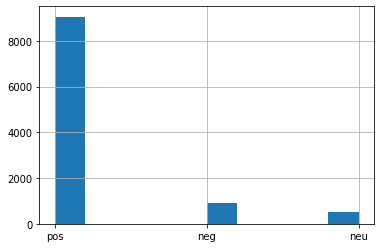

In [4]:
ptm['label'].hist()

In [60]:
len(train_dataloader.dataset)

1865

In [61]:
len(valid_dataloader.dataset)

524

In [59]:
len(test_dataloader.dataset)

99

-----------------------------------------------------------
| end of epoch   1 | time:  1.31s | valid accuracy    0.863 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  1.30s | valid accuracy    0.880 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  1.06s | valid accuracy    0.899 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  1.15s | valid accuracy    0.887 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  1.20s | valid accuracy    0.897 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  1.15s |

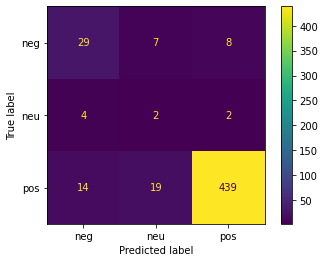

In [73]:
experimentName = "training on complete_dataset_ptm"
# Hyperparameters
EPOCHS = 10  # epoch
LR = 5  # learning rate
BATCH_SIZE = 64  # batch size for training

dataset_path = 'FinalDatasets/complete_dataset_ptm.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = reviews(root=dataset_path, split='train')

trainer = Trainer(dataset, device, LR)
train_dataloader, test_dataloader = getDatasets(dataset_path, BATCH_SIZE, trainer)
train(trainer, train_dataloader, test_dataloader)

preds, labels = predict(trainer, train_dataloader)
eval = evaluate(trainer, test_dataloader, experimentName)
results = pd.concat([results, eval])

ex_text_str1 = "Super mega proszek, bardzo dobry"
ex_text_str2 = "Totalny badziew szkoda pieniędzy, beznadziejny, porażka."
ex_text_str3 = "Nie domywa ale ładnie pachnie. Zostają smugi"
ex_text_str4 = "Nie rozpuszczają się, dobrze domywają, ładnie pachną, ale bardzo drogie"

print(f"LABEL: {reviews_labels[predictSingleEntry(trainer, ex_text_str1)]} TXT: {ex_text_str1}")
print(f"LABEL: {reviews_labels[predictSingleEntry(trainer, ex_text_str2)]} TXT: {ex_text_str2}")
print(f"LABEL: {reviews_labels[predictSingleEntry(trainer, ex_text_str3)]} TXT: {ex_text_str3}")
print(f"LABEL: {reviews_labels[predictSingleEntry(trainer, ex_text_str4)]} TXT: {ex_text_str4}")


-----------------------------------------------------------
| end of epoch   1 | time:  0.30s | valid accuracy    0.834 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  0.30s | valid accuracy    0.830 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  0.29s | valid accuracy    0.800 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  0.29s | valid accuracy    0.800 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  0.29s | valid accuracy    0.800 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  0.30s |

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


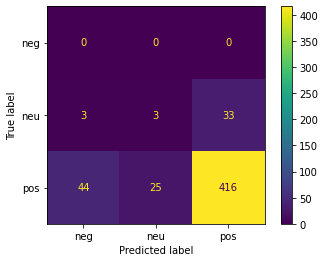

In [74]:
experimentName = "training on other_reviews"
# Hyperparameters
EPOCHS = 10  # epoch
LR = 5  # learning rate
BATCH_SIZE = 64  # batch size for training

dataset_path = 'FinalDatasets/other_reviews.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = reviews(root=dataset_path, split='train')

trainer = Trainer(dataset, device, LR)
train_dataloader, ignored = getDatasets(dataset_path, BATCH_SIZE, trainer)
train(trainer, train_dataloader, test_dataloader)

preds, labels = predict(trainer, train_dataloader)
eval = evaluate(trainer, test_dataloader, experimentName)
results = pd.concat([results, eval])

ex_text_str1 = "Super mega proszek, bardzo dobry"
ex_text_str2 = "Totalny badziew szkoda pieniędzy, beznadziejny, porażka."
ex_text_str3 = "Nie domywa ale ładnie pachnie. Zostają smugi"
ex_text_str4 = "Nie rozpuszczają się, dobrze domywają, ładnie pachną, ale bardzo drogie"

print(f"LABEL: {reviews_labels[predictSingleEntry(trainer, ex_text_str1)]} TXT: {ex_text_str1}")
print(f"LABEL: {reviews_labels[predictSingleEntry(trainer, ex_text_str2)]} TXT: {ex_text_str2}")
print(f"LABEL: {reviews_labels[predictSingleEntry(trainer, ex_text_str3)]} TXT: {ex_text_str3}")
print(f"LABEL: {reviews_labels[predictSingleEntry(trainer, ex_text_str4)]} TXT: {ex_text_str4}")


-----------------------------------------------------------
| end of epoch   1 | time:  0.29s | valid accuracy    0.721 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  0.32s | valid accuracy    0.731 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  0.28s | valid accuracy    0.687 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  0.24s | valid accuracy    0.676 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  0.24s | valid accuracy    0.676 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  0.24s |

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


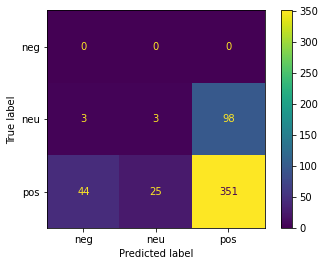

In [76]:
experimentName = "pre-training on other_reviews and training on complete_dataset_ptm"
# Hyperparameters
EPOCHS = 10  # epoch
LR = 5  # learning rate
BATCH_SIZE = 64  # batch size for training

dataset_path = 'FinalDatasets/other_reviews.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = reviews(root=dataset_path, split='train')

trainer = Trainer(dataset, device, LR)
train_dataloader, ignored = getDatasets(dataset_path, BATCH_SIZE, trainer)
train(trainer, train_dataloader, test_dataloader)

# 2nd training
dataset_path = 'FinalDatasets/complete_dataset_ptm.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = reviews(root=dataset_path, split='train')
train_dataloader, ignore = getDatasets(dataset_path, BATCH_SIZE, trainer)
train(trainer, train_dataloader, test_dataloader)

preds, labels = predict(trainer, train_dataloader)
eval = evaluate(trainer, test_dataloader, experimentName)
results = pd.concat([results, eval])

ex_text_str1 = "Super mega proszek, bardzo dobry"
ex_text_str2 = "Totalny badziew szkoda pieniędzy, beznadziejny, porażka."
ex_text_str3 = "Nie domywa ale ładnie pachnie. Zostają smugi"
ex_text_str4 = "Nie rozpuszczają się, dobrze domywają, ładnie pachną, ale bardzo drogie"

print(f"LABEL: {reviews_labels[predictSingleEntry(trainer, ex_text_str1)]} TXT: {ex_text_str1}")
print(f"LABEL: {reviews_labels[predictSingleEntry(trainer, ex_text_str2)]} TXT: {ex_text_str2}")
print(f"LABEL: {reviews_labels[predictSingleEntry(trainer, ex_text_str3)]} TXT: {ex_text_str3}")
print(f"LABEL: {reviews_labels[predictSingleEntry(trainer, ex_text_str4)]} TXT: {ex_text_str4}")


In [77]:
results

,experimentName,accuracy,recall,f1_score,training samples
0,training on complete_dataset_ptm,0.897,"[0.659, 0.25, 0.93]","[0.637, 0.111, 0.953]",9952
0,training on other_reviews,0.8,"[0.0, 0.077, 0.858]","[0.0, 0.09, 0.891]",1865
0,pre-training on other_reviews and training on ...,0.676,"[0.0, 0.029, 0.836]","[0.0, 0.045, 0.808]",9952


# Podsumowa

Model liniowy pozwala osiągnąć dobre efekty. Najlepsze efekty osiągnął model trenowany na danych z kubków, tabletek i proszków. Okazuje się, że model wytrenowany na losowych recenzjach gorzej sprawuje się w rozpoznawaniu recenzji kubków tabletek i proszków. Jest to ciekawe zjawisko. Model trenowany na recenzjach z dowolnych kategorii osiągnął 80% accuracy a trenowany na zbiorze danych z kubkami tabletkami i proszkami 90%. Spróbowaliśmy również wytrenować model najpierw na danych z losowych opnii a potem dotrenować na danych z kubkami proszkami i tabletkami. Okazało się, że to podejście nie działa najlepiej. Dochodzi do przetrenowania. model osiągnął accuracy na poziomie 67%.

(bardziej wnikliwe wnioski w sprawozdaniu)